# Programming Exercise 2: Logistic Regression

```
by Seokkyu Kong
Date: 2016-03-18
Summary: 코세라 기계학습 강의 연습문제 2번을 Octave에서 Python으로 code migration 한다.
```

[Coursera의 machine learning 강의(Andrew Ng 교수)](https://www.coursera.org/learn/machine-learning/) 내용 중 과제를 Octave에서 Python으로 변환한다.


## Introduction

여기서는 logistic regression 을 구현한다. 과제 중 ex2.m 과 ex2_reg.m 을 변환한다.

* plotData.m - Function to plot 2D classification data
* sigmoid.m - Sigmoid Function
* costFunction.m - Logistic Regression Cost Function
* predict.m - Logistic Regression Prediction Function
* costFunctionReg.m - Regularized Logistic Regression Cost

## 1. Logistic Regression

연습문제에서, 학생들의 대학입학 승인을 예측하기 위한 logistic regression model 를 구축한다. 2가지 시험점수와 승인결과를 가진 training example을 가지고 응시자의 합격 확률을 측정하는 분류 모델을 구축하는 것이 목표이다.


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 패키지를 로딩한다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# load data
data = pd.read_csv('ex2data1.txt', header=None)
data = np.array(data)
X = data[:, 0:2]
y = data[:, 2]


## EX2

### Part 1: Plotting

1.1 Visualizing the data

학습 알고리즘을 구현하기 전에 가능하면 자료를 비쥬얼화 해보는 것은 항상 좋은 일이다. 긍정과 부정은 서로 다른 마커를 가지고 표시된다.

Plotting data with + indicating (y = 1) examples and o indicating (y = 0) examples.



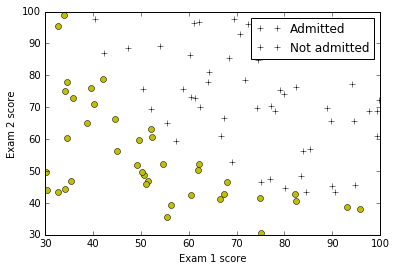

In [4]:
def plotData(X, y):
    # *******************************************************************
    # XXX: 논리값 비교 시 아래와 같이 사용하지 않는다. nonzero()를 사용한다.
    # pos = (y == 1)
    # neg = (y == 0)
    # *******************************************************************
    pos = nonzero(y == 1) # Admitted
    neg = nonzero(y == 0)

    plt.plot(X[pos, 0], X[pos, 1], 'k+', label='Admitted')
    plt.plot(X[neg, 0], X[neg, 1], 'ko', color='y', label='Not admitted')
    

print('Plotting data with + indicating (y = 1) examples and o \
indicating (y = 0) examples.\n')

plotData(X, y)

plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(('Admitted', 'Not admitted'), loc='upper right')


### Part 2: Compute Cost and Gradient

In [5]:
# data array의 크기를 조회한다.
m, n = np.shape(X)

# 절편 항목을 추가한다.
X_1 = hstack((np.ones((m, 1)), X))

# 파라미터를 초기화한다. 절편이 추가되니까 n + 1을 해준다.
initial_theta = np.zeros(n+1)

In [6]:
def sigmoid(z):
    """
    큰 양의 값에 대해서는 결과값이 1에 가깝고, 
    큰 음수의 값에 대해서는 0에 가깝다.
    simoid(0) = 0.5
    """
    g = 1 / (1  + np.exp(-z))
    
    return g

print('sigmoid(10) = %s, sigmoid(-10) = %s, sigmoid(0) = %s' 
      % (sigmoid(10), sigmoid(-10), sigmoid(0)))

sigmoid(10) = 0.999954602131, sigmoid(-10) = 4.53978687024e-05, sigmoid(0) = 0.5


In [7]:
def costFunction(theta, X, y):
    """
    cost J와 gradient를 계산한다.
    """
    m, n = X.shape
    
    """
    XXX: 
        1) array 에서 * 는 요소곱을 나타낸다. 행렬곱은 .dot() 함수를 사용한다.
        2) matrix에서 * 는 행렬곱을 나타낸다. 요소곱은 .multiply() 함수를 사용한다.
        3) 함수 안에서는 matrix 연산으로 통일한다.
    """
    predictions = sigmoid(X.dot(theta))
    
    # cost J를 구한다.
    J = 1/m * sum(-y * log(predictions) - (1 - y) * log(1 - predictions))
    
    # gradient를 구한다.
    errors = predictions - y

    delta = 1/m * errors.T.dot(X)
    grad = delta
    
    return J, grad

# Test Script
X1 = np.array([[1, 8, 1, 6],
    [1, 3, 5, 7],
    [1, 4, 9, 2]]);
y1 = np.array([1, 0, 1]);
theta1 = np.array([-2, -1, 1, 2]);

j, r = costFunction(theta1, X1, y1)
print(j)
print (r)

"""
% results
j = 4.6832

g =
  0.31722
  0.87232
  1.64812
  2.23787
"""


4.68316654981
[ 0.31722075  0.87231544  1.6481235   2.23787228]


'\n% results\nj = 4.6832\n\ng =\n  0.31722\n  0.87232\n  1.64812\n  2.23787\n'

In [8]:
# initial_theta가 모두 0일 경우의 cost, gradient를 구한다.
cost, grad = costFunction(initial_theta, X_1, y)

# Cost at initial theta (zeros): 0.693147 
print('Cost at initial theta (zeros): %f \n' % cost)

print('Gradient at initial theta (zeros): \n')
# [[ -0.1        -12.00921659 -11.26284221]]
print('%s' % grad)

Cost at initial theta (zeros): 0.693147 

Gradient at initial theta (zeros): 

[ -0.1        -12.00921659 -11.26284221]


### Part 3: Optimizing using fminunc

In [9]:
"""
http://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
http://docs.scipy.org/doc/scipy-0.10.0/reference/tutorial/optimize.html
http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

# 아래 stackoverflow 내용 중 소스코드가 많은 도움이 되었다.
http://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy (*****)
http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/ (***)
"""

# minimize 함수 호출을 사용하기 위해 import 한다.
import scipy.optimize as op

# octave 에서는 costFunction 안에서 cost와 gradient를 한꺼번에 계산했다.
# python 에서는 minimize () 사용을 위해서 cost와 gradient 계산을 분리한다.

def myCost(theta, X, y):
    """
    cost J를 계산한다.
    """
    
    m, n = X.shape
    # 아래와 같은 방식으로 사용하지 말자.
    #theta1 = theta.reshape(len(theta), 1, order='F').copy()

    predictions = X.dot(theta)
    sig_term = sigmoid(predictions)
    
    # 원본 수식
    J = 1/m * np.sum(-y * log(sig_term) - (1 - y) * log(1 - sig_term))
    
    return J

def myGradient(theta, X, y):
    """
    gradient를 계산한다.
    """
    m, n = np.shape(X)

    # errors 의 차원을 확인해야 한다. predictions과 동일한 차원인지 확인한다.
    # dim(predictions) = dim(erros) = dim(y) = m x 1
    predictions = sigmoid(X.dot(theta))
    errors = predictions - y
    
    delta = 1/m * errors.T.dot(X) # => 1 x n
    grad = delta

    # ********************************************************************
    # XXX: 함수내에서 gradient 반환은 array 타입으로 반환하는 것이 중요하다.
    # return format: array([ -0.1       , -12.00921659, -11.26284221])
    # ********************************************************************
    return grad


Result = op.minimize(fun = myCost, x0 = initial_theta, args = (X_1, y), method = 'TNC'
                     , jac = myGradient);
#Result = op.fmin_tnc(func = myCost, x0 = initial_theta, fprime = myGradient, args = (X_1, y))

cost = Result.fun
theta = Result.x

# Cost at theta found by fminunc: 0.203497701589. 
print('Cost at theta found by fminunc: %s. \n' % cost)

# theta: [-25.16131861   0.20623159   0.20147149]
print('theta: %s. \n' % theta)


# XXX: 아래 방식 fmin_bfgs()는 잘못된 결과가 나오는데, 
# 어떤 부분이 잘못되었는지 모르겠다. 추후 검토 필요함
#Result = op.fmin_bfgs(f = myCost, x0 = initial_theta, args = (X_1, y), maxiter = 400, fprime = myGradient)
#print (myCost(Result[0], X_1, y))

Cost at theta found by fminunc: 0.203497701589. 

theta: [-25.16131863   0.20623159   0.20147149]. 



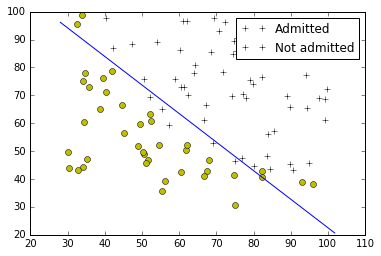

In [10]:
def plotDecisionBoundary(theta, X, y):
    plotData(X[:, 1:3], y)
    
    if np.size(X, 1) <= 3:
        # line을 정의하기 위해서는 단지 2개의 점만 필요하다. 
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1] + 2)])
        
        # ***************************************************************
        # XXX: decision boundary line을 계산한다.
        # theta0 + theta1 * x + theta2 * y = 0
        # ***************************************************************
        plot_y = (-1 / theta[2]) * (theta[1] * plot_x + theta[0])
        
        # plot을 그린다.
        plot(plot_x, plot_y)
        
        # Legend를 표시한다.
        plt.legend(('Admitted', 'Not admitted'), loc='upper right')
        
    
    # 변환 작업 중
    else:
        # grid range를 설정한다. linspace는 octave, python 동일한 사용법임
        u = linspace(-1, 1.5, 50)
        v = linspace(-1, 1.5, 50)
        
        z = np.zeros((np.size(u), np.size(v)))
        
        # z = theta * x 를 grid 상에서 평가한다.
        for i in np.arange(np.size(u)):
            for j in np.arange(np.size(v)):
                z[i, j] = np.sum(mapFeature(u[i], v[j]) * theta)
                
        # contour를 호출하기 전에 transpose하는 것이 중요하다.
        z = z.T
        # Plot z = 0
        # range를 [0, 0]으로 할 필요가 있다.
        plt.contour(u, v, z)
     
     

plotDecisionBoundary(theta, X_1, y)


### Part 4: Predict and Accuracies

파라미터를 학습한 이후에 여태껏 본적 없는 데이터에 대해서 결과를 예측하기 위해 모델을 사용할 수 있다. 시험 1에 대해서 45점, 시험 2에 대해서 85점을 받은 학생이 학교의 승인을 받을 확률을 계산할 수 있다.

predict 함수는 주어진 데이터와 theta를 이용해서 1 또는 0의 예측값을 만들어낸다.

In [14]:
# 확률이 50% 를 넘으므로, 합격으로 예측한다.
# array 에서 * 는 요소곱이다. 따라서 np.sum 을 이용해 곱의 합을 구한다.



def predict(theta, X):
    """
    파라미터 theta와 X 에 의한 결과값을 예측한다.
    """
    p = sigmoid(X.dot(theta)) >= 0.5;
    
    return p
    
# training set 에 대한 정확도(accuracy)를 계산한다.
# Train Accuracy: 89.000000
p = predict(theta, X_1)

print('Train Accuracy: ', np.mean(double(p == y)) * 100)

Train Accuracy:  89.0


## 2. Regularized logistic regression

연습문제의 이 부분에서는 제조공정의 마이크로칩이 QA를 통과할지 대한 여부를 예측하게 된다. QA 동안, 마이크로칩은 기능이 올바르게 동작하는지 확인하기 위해 여러가지 테스트를 거친다.

당신이 공장의 제품 매니저라고 가정하자. 2개의 서로 다른 테스트 결과로부터 마이크로칩이 통과할지 그렇지 않을지를 결정하고 싶어한다. 의사결정을 돕기 위해 과거 테스트 결과 데이터셋을 가지고 있고 그것을 이용해서 logistic regression model 을 구축할 수 있다.

ex2_reg.m 스크립트를 사용해서 나머지 연습문제를 해결한다.

### 2.1 Visualizing the data

이전 연습문제와 비슷하게 plotData는 Figure 3.과 같은 그림을 만들기 위해 사용된다. positive 는 y=1 이고 accept 된것을 의미한다. negative 는 y=0 이고 reject 된 것을 의미한다.


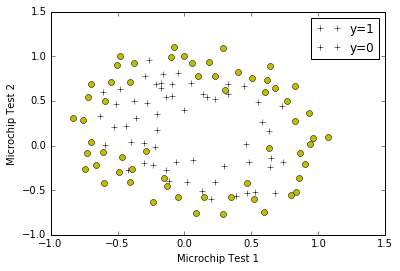

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('ex2data2.txt', header=None)
data = np.array(data)
X = data[:, 0:2]
y = data[:, 2]

plotData(X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(('y=1', 'y=0'), loc='upper right')


데이터가 직선으로 분리될 수 없음을 알 수 있다. 따라서 logistic regression 의 직선은 이 데이터에 적용할 수 없다.

### 2.2 Feature mapping

**data를 더 잘 맞게(fit) 하는 방법은 각각의 data point 로 부터 더 많은 feature를 생성하는 것이다.** 제공된 함수 mapFeature.m 에서 feature들을 다항식 항목인 x1과 x2를 이용해서 6차까지 매핑할 것이다.

이 매핑의 결과로 2개의 feature로 이루어진 벡터는 28 dimension vector로 변환된다.

고차원의 피처 벡터 상에서 훈련된 logistic regression classifier는 더 복잡한 decision boundary를 갖게 되고 **2차 평면에 그려질 때 nonlinear (직선이 아닌) 로 나타나게 된다.**

**feature mapping 이 더욱 표현이 좋은 분류기를 구축하지만 반면에 overffiting 에 더욱 민감해 진다.** 연습문제의 나머지에서 regularized logistic regression 을 구현해서 data를 fit 하게 되고 regularization 이 어떻게 overffiting 과 싸우는데 도움이 되는지 직접 확인할 것이다.

### 2.3 Cost function and gradient



### Part 1: Regularized Logistric Regression


In [16]:
# Polynomial features를 추가한다.
# mapFeature는 intercept term(절편 항목)인 1의 컬럼을 추가한다.

def mapFeature(X1, X2):
    """
    주어진 데이터를 다항식 항목의 feature로 갯수를 늘려준다.
    """
    
    degree = 6
    
    #print(X1.shape)
    
    m = np.size(X1)
    out = np.ones(m) # 1로 채워진 절편 컬럼 벡터
    
    # XXX: 벡터 단위로 계산된 내용을 list에 추가하는 방식이 편하다.
    # 계산된 컬럼 벡터를 list에 추가한다.
    # res = [[1,1,1,], [2,2,2,], [3,3,3,]]
    res = []
    res.append(out)
    
    for i in np.arange(1, degree + 1):
        for j in np.arange(0, i + 1):
            # ***************************************************************
            # XXX: 아래와 같은 수식은 어떻게 만드는걸까?
            # ***************************************************************
            out1 = (X1 ** (i - j)) * (X2 ** j)
            res.append(out1)
    
    # list에 저장된 것을 2차원 array 벡터로 변환하고 전치 시켜서 반환한다.
    return np.array(res).T

# X_reg: 118 x 28 dimension, 절편이 포함되어 있다.
X_reg = mapFeature(X[:, 0], X[:, 1])

print(X_reg[0:2, :])

[[  1.00000000e+00   5.12670000e-02   6.99560000e-01   2.62830529e-03
    3.58643425e-02   4.89384194e-01   1.34745327e-04   1.83865725e-03
    2.50892595e-02   3.42353606e-01   6.90798869e-06   9.42624411e-05
    1.28625106e-03   1.75514423e-02   2.39496889e-01   3.54151856e-07
    4.83255257e-06   6.59422333e-05   8.99809795e-04   1.22782870e-02
    1.67542444e-01   1.81563032e-08   2.47750473e-07   3.38066048e-06
    4.61305487e-05   6.29470940e-04   8.58939846e-03   1.17205992e-01]
 [  1.00000000e+00  -9.27420000e-02   6.84940000e-01   8.60107856e-03
   -6.35227055e-02   4.69142804e-01  -7.97681228e-04   5.89122275e-03
   -4.35092419e-02   3.21334672e-01   7.39785525e-05  -5.46363780e-04
    4.03513411e-03  -2.98012201e-02   2.20094970e-01  -6.86091891e-06
    5.06708697e-05  -3.74226408e-04   2.76382476e-03  -2.04120477e-02
    1.50751849e-01   6.36295342e-07  -4.69931780e-06   3.47065055e-05
   -2.56322636e-04   1.89305413e-03  -1.39810280e-02   1.03255971e-01]]


costFunctionReg.m 을 작성한다.

주의사항: theta0를 regularize 하면 안된다.

In [30]:
def costFunctionReg(theta, X, y, s_lambda):
    
    """
    regularization을 가진 logistic regression 의 cost와 gradient를 계산한다.
    """
    
    m, n = X.shape
    #m = np.size(y) # training examples 갯수
    
    # 아래 값을 올바르게 반환해야 한다.
    J = 0
    grad = np.zeros(np.size(theta))
    
    """
    cost는 J 값으로 설정한다. 편미분을 계산하고 결과를 grad에 설정한다.
    
    힌트: cost 함수와 gradient 계산은 효율적으로 벡터화될 수 있다. 예를 들어 다음
    계산을 생각해보자. 
    
    sigmoid(X * theta)
    
    결과 행렬의 각 row는 해당 example의 예측값이 된다. 
    
    힌트: regularized cost 함수의 gradient를 계산할 때, 많은 벡터화 솔루션이 있지만
    한가지 가능한 방법은 아래와 같다
    
    grad = = (unregularized gradient for logistic regression)
    temp = theta; 
    temp(1) = 0;   % because we don't add anything for j = 0  
    grad = grad + YOUR_CODE_HERE (using the temp variable)
 
    """
    
    # sum_theta_square는 theta[0]를 포함하지 않는다. 
    sum_theta_square = np.sum(theta[1:] ** 2)
    
    # 예측값을 계산한다.
    X_theta = X.dot(theta)
    prediction = sigmoid(X_theta)

    # cost J를 계산한다.
    J = 1/m * np.sum(-y * log(prediction) - (1 - y) * log(1 - prediction)) \
        + s_lambda / (2 * m) * sum_theta_square
        
    # 편미분을 계산한다.
    error = prediction - y
    delta = 1/m * error.T.dot(X)
    
    temp = theta
    temp[0] = 0
    regular = (s_lambda / m) * temp
    
    grad = delta + regular
    
    return J, grad

# initial_theta: 28 x 1
initial_theta = np.zeros(X_reg.shape[1])

# regularization 파라미터 lambda를 1로 설정한다.
# lambda 는 python 키워드이기 때문에 변수명을 s_lambda로 사용한다.
s_lambda = 1

# regularized logistic regression 에 대한 초기 cost 와 gradient 를 구한다.
cost, grad = costFunctionReg(initial_theta, X_reg, y, s_lambda)

# cost is 0.69314718056 and grad is [  8.47457627e-03   1.87880932e-02   7.77711864e-05   5.03446395e-02
print('cost is %s and grad is %s. \n' % (cost, grad))



cost is 0.69314718056 and grad is [  8.47457627e-03   1.87880932e-02   7.77711864e-05   5.03446395e-02
   1.15013308e-02   3.76648474e-02   1.83559872e-02   7.32393391e-03
   8.19244468e-03   2.34764889e-02   3.93486234e-02   2.23923907e-03
   1.28600503e-02   3.09593720e-03   3.93028171e-02   1.99707467e-02
   4.32983232e-03   3.38643902e-03   5.83822078e-03   4.47629067e-03
   3.10079849e-02   3.10312442e-02   1.09740238e-03   6.31570797e-03
   4.08503006e-04   7.26504316e-03   1.37646175e-03   3.87936363e-02]. 



In [18]:

Xt = np.array([[1, 8, 1, 6],
    [1, 3, 5, 7],
    [1, 4, 9, 2]])
yt = np.array([1, 0, 1])
thetat = np.array([-2, -1, 1, 2])

j = 0
g = 0
# un-regularized
#j, g = costFunctionReg(thetat, Xt, yt, 0)
# note: also works for [j g] = costFunction(theta, X, y)

#print(j, g)
# results
#j = 4.6832

#g =
#  0.31722
#  0.87232
#  1.64812
#  2.23787


# regularized
#j, g = costFunctionReg(thetat, Xt, yt, 3)
g = myGradientReg(thetat, Xt, yt, 3)
# note: also works for ex3 lrCostFunction(theta, X, y, 3)

print(j, g)
# results
#j = 7.6832

#g =
#  0.31722
#  -0.12768
#  2.64812
#  4.23787



NameError: name 'myGradientReg' is not defined

### Part 2: Regularization and Accuracies

여기서는 lambda값을 서로 다르게 했을 때, regularization 이 decision boundary에 어떤 영향을 미치는지 알아보도록 한다.

lambda를 0, 1, 10, 100으로 각각 설정해본다.

이때 decision boundary와 training set의 accuracy가 어떻게 변화하는가?

In [28]:
# minimize 함수 호출을 사용하기 위해 import 한다.
import scipy.optimize as op

# octave 에서는 costFunction 안에서 cost와 gradient를 한꺼번에 계산했다.
# python 에서는 minimize () 사용을 위해서 cost와 gradient 계산을 분리한다.

def myCostReg(theta, X, y, s_lambda):
    """
    cost J를 계산한다.
    """
    # 출력될 값을 미리 선언한다.
    J = 0
    grad = np.zeros(np.size(theta))
    
    m, n = X.shape

    # 1) cost J(theta) 값을 구한다.
    # theta 는 array 타입이다. 따라서 요소 제곱합이 계산된다.
    sum_theta_square = np.sum(theta[1:] ** 2)

    # 예측값에 대한 sigmoid를 구한다.
    predictions = sigmoid(X.dot(theta))
    
    # 비용 cost J를 구한다.
    J = 1/m * np.sum(-y * log(predictions) - (1 - y) * log(1 - predictions)) \
        + s_lambda / (2 * m) * sum_theta_square
    
    return J

def myGradientReg2(theta, X, y, s_lamdba):
    j, g = costFunctionReg(theta, X, y, s_lambda)

    return g

def myGradientReg(theta, X, y, s_lambda):
    """
    gradient를 계산한다.
    """    
    # 출력될 값을 미리 선언한다.
    J = 0
    grad = np.zeros(np.size(theta))
    
    m, n = X.shape
    
    # 예측값에 대한 sigmoid를 구한다.
    predictions = sigmoid(X.dot(theta))
    
    # 2) theta 편미분 값을 구한다.
    # theta_0 에 대한 편미분값을 구한다.
    errors = predictions - y
    
    # Part 1과 Part 2는 같은 식이지만, minimize 수행 시 
    # 서로 다른 gradient를 가진다. 왜???? -_-;
    
    """
    # *****************************************
    # Part 1: 
    delta = 1/m * errors.T.dot(X)
    
    temp = theta
    temp[0] = 0
    regular = (s_lambda / m) * temp
    
    grad = delta + regular
    """ 
    
    # *****************************************
    # Part 2: 
    # 1) cost J(theta) 값을 구한다.
    
    theta_0 = theta[0]
    theta_j = theta[1:]
    
    # 첫번째 컬럼 bias에 대해서 계산
    delta_0 = 1/m * errors.T.dot(X[:, 0]) 

    # theta_j 에 대한 편미분값을 구한다.
    delta_j = 1/m * errors.T.dot(X[:, 1:])
    
    # regularization term 계산
    regular = s_lambda / m * theta_j    
    delta_j = delta_j.T + regular
    
    grad[0] = delta_0
    grad[1:] = delta_j.T
    
    #print(grad[0])
    
    return grad



initial_theta = np.zeros(X_reg.shape[1])
#s_lambda = 0 # cost = 0.257
s_lambda = 1 # cost = 0.529
#s_lambda = 10 # cost = 0.648
#s_lambda = 100 # cost = 0.686

Result = op.minimize(fun = myCostReg, x0 = initial_theta, args = (X_reg, y, s_lambda), \
                     method = 'TNC', jac = myGradientReg, options = {'maxiter': 400});

cost = Result.fun
theta = Result.x

# In Octave: Cost at theta found by fminunc: 0.529004
print('Cost at theta found by fminunc: %s. \n' % cost)

"""
In Octave: 
theta: 
 1.273005 
 0.624876 
 1.177376 
 -2.020142 
 -0.912616 
 -1.429907 
"""
print('theta: %s. \n' % theta)


Cost at theta found by fminunc: 0.529002729964. 

theta: [ 1.27271027  0.62529965  1.18111686 -2.01987399 -0.91743189 -1.43166929
  0.12393227 -0.36553118 -0.35725403 -0.17516291 -1.4581701  -0.05098418
 -0.61558552 -0.27469165 -1.19271297 -0.2421784  -0.20603297 -0.04466178
 -0.27778952 -0.29539513 -0.45645982 -1.04319155  0.02779373 -0.29244872
  0.01555761 -0.32742406 -0.1438915  -0.92467487]. 



plotDecisionBoundary.m, we plot the non-linear decision boundary by com- puting the classifier’s predictions on an evenly spaced grid and then and drew a contour plot of where the predictions change from y = 0 to y = 1.

plotDecisionBoundary.m 은 비선형 decision boundary를 그리는데, 평형공간상의 그리드에 분류자의 예측을 계산하고 y=0에서 y=1일 때의 예측 변화를 contour plot으로 그린다.

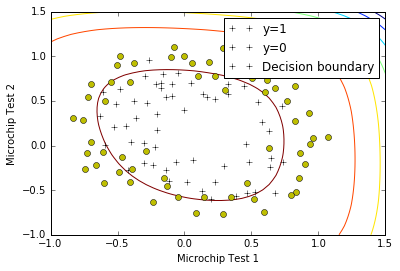

In [29]:
# 경계선을 그린다.
plotDecisionBoundary(theta, X_reg, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
# 경계선을 그린다.

plt.legend(('y=1', 'y=0', 'Decision boundary'), loc='upper right')


In [84]:
# training set에 대한 정확도(accuracy)를 계산한다.

p = predict(theta, X_reg)

# In Octave: Train Accuracy: 83.050847
print('Train Accuracy: %s' % np.mean(double(p == y)))

Train Accuracy: 0.533898305085
